# Wildlife Species Identification in Camera Trap Images
> * 🔬 Data Science
> * 🥠 Deep Learning and Image Classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
 * [Data selection](#Data-selection)
 * [Prepare data](#Prepare-data)
 * [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
* [Train the model](#Train-the-model)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model Inference](#Model-inference)
 * [Data preparation](#Data-preparation)
 * [Inferencing](#Inferencing) 
* [Conclusion](#Conclusion)

## Introduction 

Automatic animal identification can improve biology missions that require identifying species and counting individuals, such as animal monitoring and management, examining biodiversity, and population estimation.

This notebook will showcase a workflow to classify animal species in camera trap images. The notebook has two main sections:
1. Training a deep learning model that can classify animal species  
2. Using the trained model to classify animal species against each camera location

We have used a subset of a community licensed open source dataset for camera trap images, provided under the [LILA BC](http://lila.science/) (Labeled Information Library of Alexandria: Biology and Conservation) repository, to train our deep learning model, which is further detailed in [this](#Get-the-data-for-analysis) section. For inferencing, we have taken 5 fictional camera locations in Kruger National Park, South Africa, and to each of those points, we have attached some images. This feature layer simulates a scenario where there are multiple cameras at different locations that have captured images that need to be classified for animal species. The whole workflow enabling this is explained in [this](#Model-inference) section.

Note: This notebook is supported in ArcGIS Enterprise 10.9 and later.

## Necessary imports 

In [1]:
import os
import json
import zipfile
import pandas as pd
from pathlib import Path
from fastai.vision import ImageDataBunch, get_transforms, imagenet_stats

from arcgis.gis import GIS
from arcgis.learn import prepare_data, FeatureClassifier, classify_objects, Model

## Connect to your GIS 

In [2]:
# connect to web GIS
gis = GIS("Your_enterprise_profile")                               # ArcGIS Enterprise 10.9 or later

## Get the data for analysis

In this notebook, we have used the "WCS Camera Traps" dataset, made publicly available by the [Wildlife Conservation Society](https://www.wcs.org/) under the [LILA BC repository](http://lila.science/). This dataset contains approximately 1.4M camera trap images representing different species from 12 countries, making it one of the most diverse camera trap data sets publicly available. The dataset can be further explored and downloaded from [this link](http://lila.science/datasets/wcscameratraps). This data set is released under the [Community Data License Agreement (permissive variant)](https://cdla.io/permissive-1-0/).

### Data selection

This dataset has 1.4M images related to 675 different species, of which we have chosen 11 species whose conservation status was either "Endangered", "Near Threatened", or "Vulnerable". These species include Jaguars, African elephants, Lions, Thomson's gazelles, East African oryxs, Gerenuks, Asian elephants, Tigers, Ocellated turkeys, and Great curassows.

The json file (wcs_camera_traps.json) that comes with the data contains metadata we require.
The cell below converts the downloaded data into required format to be used by `prepare_data()`.

In [3]:
# # list containing corrupted filenames from the data downloaded
# corrupted_files=['animals/0402/0905.jpg', 'animals/0407/1026.jpg', 'animals/0464/0880.jpg',  
#                  'animals/0464/0881.jpg', 'animals/0464/0882.jpg', 'animals/0464/0884.jpg',
#                  'animals/0464/0888.jpg', 'animals/0464/0889.jpg', 'animals/0645/0531.jpg',
#                  'animals/0645/0532.jpg', 'animals/0656/0208.jpg', 'animals/0009/0215.jpg']

# # list with selected 11 species ids
# retained_specie_list = [7,24,90,100,119,127,128,149,154,372,374]  

# with open('path_to: wcs_camera_traps.json') as f:
#     metadata = json.load(f)
# annotation_df = pd.DataFrame(metadata['annotations'])                 # load the annotations and images into a dataframe
# images_df = pd.DataFrame(metadata['images'])
# img_ann_df = pd.merge(images_df,
#                       annotation_df,
#                       left_on='id',
#                       right_on='image_id',
#                       how='left').drop('image_id', axis=1)

# train_df = img_ann_df[['file_name','category_id']]                    # selecting required columns from the merged dataframe.
# train_df = train_df[~train_df['file_name'].isin(corrupted_files)]     # removing corrupted files from the dataframe
# train_df = train_df[~img_ann_df['file_name'].str.contains("avi")]

# # A 'category_id' of 0 indicates an image that does not contain an animal. 
# # To reduce the class imbalance, we will only retain
# # ~50% of the empty images in our training dataset.
# new_train_df = train_df[train_df['category_id']==0].sample(frac=0.5,
#                                                     random_state=42)
# new_train_df = new_train_df.append(train_df[train_df['category_id']
#                                             .isin(retained_specie_list)])

Alternatively, we have provided a subset of training data containing a few samples from the 11 species mentioned above.

In [3]:
agol_gis = GIS("home")

<Item title:"wildlife_species_identification_in_camera_trap_images" type:Image Collection owner:api_data_owner>
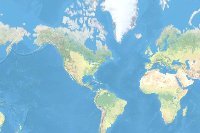

In [4]:
training_data = agol_gis.content.get('677f0d853c85430784169ce7a4a54037')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [8]:
new_train_df = pd.read_csv(str(output_path)+'/retained_data_subset.csv')

In [9]:
new_train_df

,file_name,category_id
0,animals/0015/0738.jpg,0
1,animals/0057/1444.jpg,0
2,animals/0407/0329.jpg,0
3,animals/0321/1855.jpg,0
4,animals/0224/1005.jpg,0
...,...,...
1796,animals/0389/1309.jpg,374
1797,animals/0389/1310.jpg,374
1798,animals/0389/1311.jpg,374
1799,animals/0389/1312.jpg,374


### Prepare data 

Here, we are not using the `prepare_data()` function provided by `arcgis.learn` to prepare the data for analysis. Instead, we will use the `ImageDataBunch.from_df` method provided by fast.ai to read the necessary information from a dataframe and convert it into a 'DataBunch' object, which will then be used for training. We will use the standard set of transforms for data augmentation and use 20% of our training dataset as a validation dataset. It is important to note that we are also normalizing our inputs.

In [10]:
Path_df=Path(output_path)                                           # path to the downloaded data
data = ImageDataBunch.from_df(path=Path_df,
                              folder='',
                              df=new_train_df,
                              fn_col=0,
                              label_col=1,
                              valid_pct=0.2,
                              seed=42,
                              bs=16,
                              size=224,
                              num_workers=2).normalize(imagenet_stats)

### Visualize a few samples from your training data

When working with large sets of jpeg images, it is possible that some images will only be available as a stream coming from an image and will not be complete. If these image streams are present in the dataset, they could potentially break the training process. To ensure that the training flow does not break, we set the LOAD_TRUNCATED_IMAGES parameter to True to indicate that the model should train on whatever image stream is available.

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

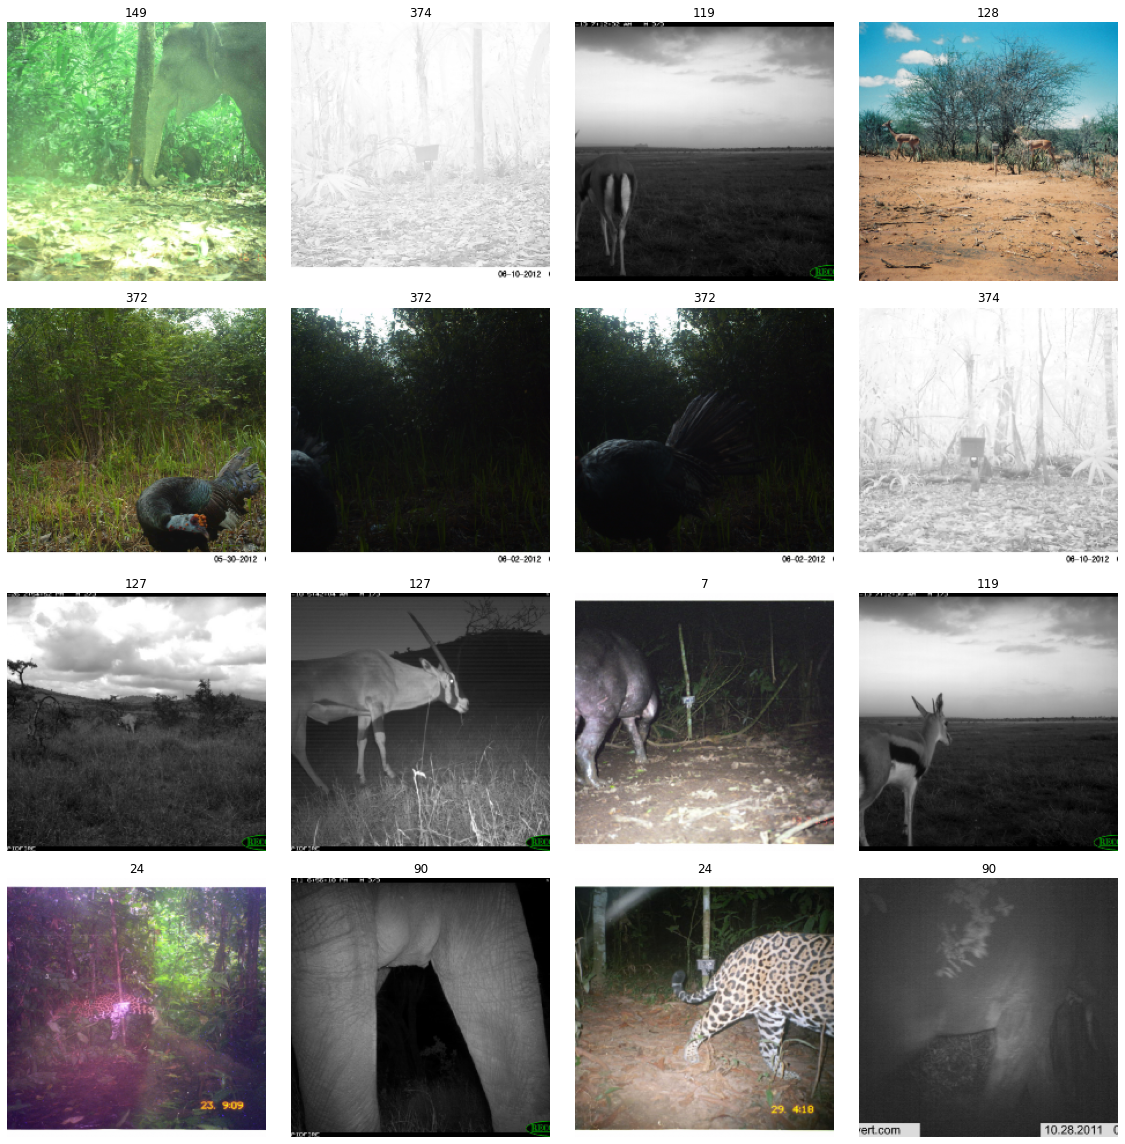

In [12]:
data.show_batch(5)

## Train the model 

### Load model architecture

The `arcgis.learn` module provides the ability to determine the class of each feature in the form of the `FeatureClassifier` model. For more in-depth information about it's working and usage, see this [link](https://developers.arcgis.com/python/guide/how-feature-categorization-works/). For our training, we will use a model with the 34 layered 'ResNet' architecture.

In [13]:
model = FeatureClassifier(data)

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rates to guide us to choosing the best one. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We will use the `lr_find()` method to find the optimum learning rate at which we can train a robust model, while still considering the speed and efficiency of the model.

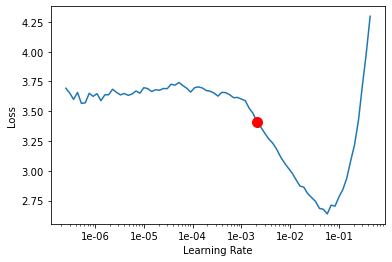

In [14]:
lr = model.lr_find()

In [15]:
lr

0.0020892961308540407

Based on the learning rate plot above, we can see that the learning rate suggested by `lr_find()` for our training data is 0.002. We can now use this learning rate to train our model. However, in the latest release of `arcgis.learn`, we can now train models without even specifying a learning rate. This new functionality will use the learning rate finder to determine and implement an optimal learning rate.

### Fit the model

To train the model, we use the `fit()` method. To start, we will use 5 epochs to train our model. The number of epochs specified will define how many times the model is exposed to the entire training set.

Note: The results displayed below are obtained after training on the complete dataset belonging to the 11 species specified above. However, the dummy training data provided may not produce similar results.

In [16]:
model.fit(5, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.585832,0.393099,0.869444,03:12
1,0.687256,0.292758,0.911111,03:06
2,0.380574,0.211873,0.938889,03:04
3,0.201335,0.199844,0.947222,03:10
4,0.162608,0.182794,0.947222,03:02


### Visualize results in validation set

Notice that after training our model for 5 epochs, we are already seeing ~95% accuracy on our validation dataset. We can further validate this by selecting a few random samples and displaying the ground truth and respective model predictions side by side. This allows us to validate the results of the model in the notebook itself. Once satisfied, we can save the model and use it further in our workflow.

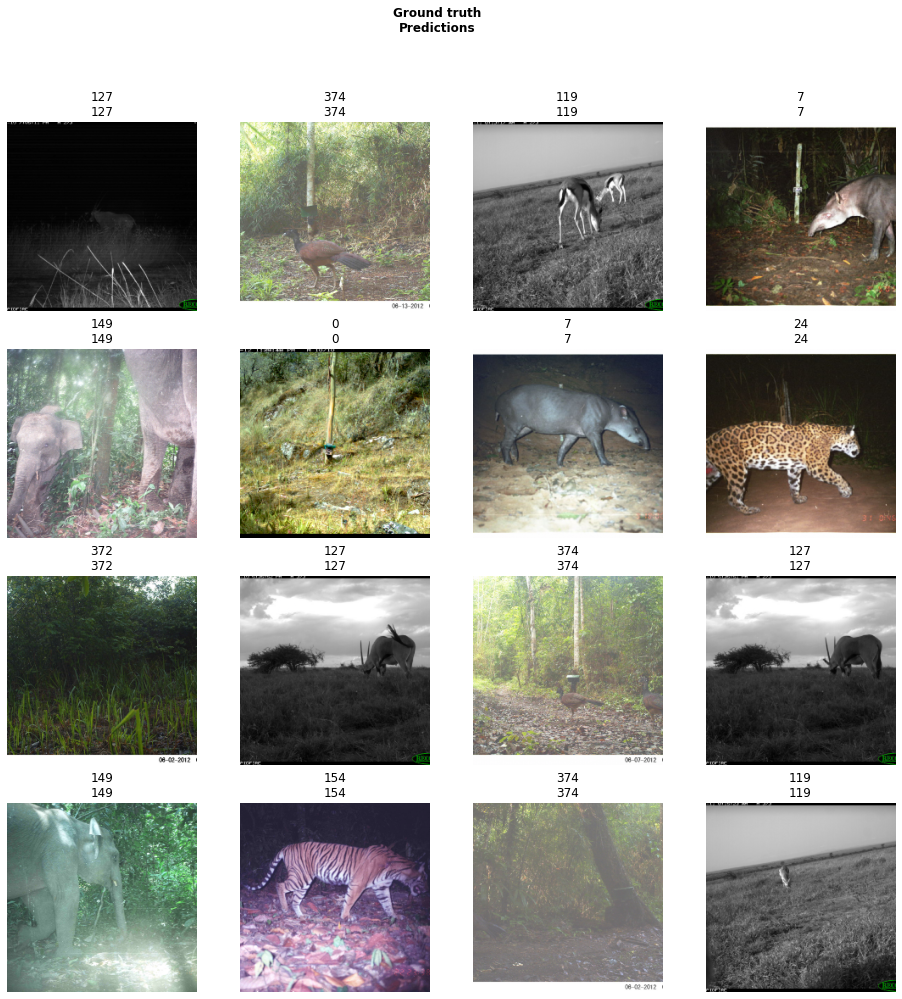

In [17]:
model.show_results(rows=8, thresh=0.2)

Here, a subset of ground truths from the training data is visualized alongside the predictions from the model. As we can see, our model is performing well, and the predictions are comparable to the ground truth.

### Save the model

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save('Wildlife_identification_model', publish=True, overwrite=True)

## Model inference

This section demonstrates the application of our trained animal species classification model on the images stored as feature attachments. 

### Data preparation 

To start, we have a feature class named "CameraTraps" that contains 5 features that are hosted on our enterprise account. We will consider these features to be camera locations. We also have multiple locally stored images for each of these camera locations that we want to use against our model.

<Item title:"CameraTraps" type:Feature Layer Collection owner:portaladmin>
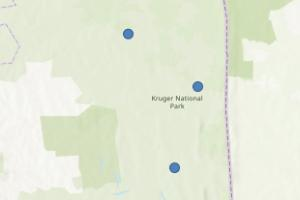

In [20]:
# Accessing the feature layer on the enterprise.

search_result = gis.content.search("title: CameraTraps owner:portaladmin", 
                                 "Feature Layer")
cameratraps = search_result[0]
cameratraps

In [21]:
# Cloning the item to local enterprise account

gis.content.clone_items([cameratraps])

[<Item title:"CameraTraps" type:Feature Layer Collection owner:portaladmin>]

<Item title:"CameraTraps" type:Feature Layer Collection owner:portaladmin>
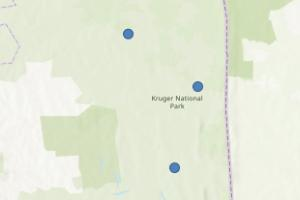

In [22]:
search_result = gis.content.search("title: CameraTraps owner:portaladmin", 
                                 "Feature Layer")
cameratraps_clone = search_result[0]
cameratraps_clone

In [23]:
cr_lyr = cameratraps_clone.layers[0]

In order to attach images to each of these camera locations, we need to enable attachments to the feature layer.

In [24]:
cr_lyr.manager.update_definition({"hasAttachments": True})

{'success': True}

In [25]:
cr_lyr.query().sdf

,globalid,objectid,SHAPE
0,{099AC399-BBA2-4D27-BB86-3039DBEE1547},1,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
1,{878DE63D-1922-4AD5-9E92-D645119B1083},2,"{""x"": 3522933.4897000007, ""y"": -2791843.061000..."
2,{1339C84F-DBBC-40C1-BE30-021AAA443DAA},3,"{""x"": 3550955.0551999994, ""y"": -2813053.829399..."
3,{4878288B-51BA-4E86-B583-89B12DC5524F},4,"{""x"": 3541614.533399999, ""y"": -2845745.6558, ""..."
4,{C073C447-EF6F-42C3-914E-7906D3B9E587},5,"{""x"": 3519430.7939999998, ""y"": -2867734.800999..."


Now, we can specify the path on the local drive where images are stored against each camera location. One important point to note here, is that the directory structure of the data folder path should have separate folders with the 'objectid' of the camera location points as their names and that contain all of the photos captured by that camera.

In our case, as we have 5 camera locations, we had a data folder containing 5 different folders with the names 1, 2, 3, 4, and 5 as the 'objectid' of the points (see the spatial dataframe table above). Each of these folders had multiple images captured by the cameras. Below is a diagram of the folder structure mentioned:

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAWQAAACzCAYAAAC+V2YDAAAGz3RFWHRteGZpbGUAJTNDbXhmaWxlJTIwaG9zdCUzRCUyMmFwcC5kaWFncmFtcy5uZXQlMjIlMjBtb2RpZmllZCUzRCUyMjIwMjAtMDktMDFUMDclM0EyOCUzQTMzLjE5MVolMjIlMjBhZ2VudCUzRCUyMjUuMCUyMChXaW5kb3dzJTIwTlQlMjAxMC4wJTNCJTIwV2luNjQlM0IlMjB4NjQpJTIwQXBwbGVXZWJLaXQlMkY1MzcuMzYlMjAoS0hUTUwlMkMlMjBsaWtlJTIwR2Vja28pJTIwQ2hyb21lJTJGODUuMC40MTgzLjgzJTIwU2FmYXJpJTJGNTM3LjM2JTIyJTIwZXRhZyUzRCUyMkgxdU50SmFlQjg5d3IzUjZxZ0IwJTIyJTIwdmVyc2lvbiUzRCUyMjEzLjAuMSUyMiUyMHR5cGUlM0QlMjJkZXZpY2UlMjIlM0UlM0NkaWFncmFtJTIwaWQlM0QlMjJUYkJIVkxEbzlpTWRwdDdFd3lXOCUyMiUyMG5hbWUlM0QlMjJQYWdlLTElMjIlM0U3WnBkYjVzd0ZJWiUyRkRaZEZZT01BbCUyQm5YSm0zZFdsVmF1MHMzZU1RVndjZzRLZW12bnlubUt5WnBxeVlRcWw0bFBwaUQlMkZiekd2SnpFZ0dlTDdCdkh5ZnlLQlNReWdCVmtCanczQUxBdDZNbVBQTEl1SXNpemlrRElhYUE2MVlGYiUyQmt6S00xVjBTUU9TdGpvS3hpSkJrM1p3eHVLWXpFUXJoamxuVCUyQjF1JTJGMWpVdm1xQ1E2SUZibWM0MHFOM05CRHpJdW9ocTQ1JTJGSnpTY2wxZTJMWFZrZ2N2T0twRE9jY0NlR2lGNFljQXp6cGdvdmkyeU14TGw4RW91eFhtWFc0NVdBJTJCTWtGbTg1SVVsdjdPbWZLJTJGRDdMbnY4NFU5JTJGclc2dWJrNWNOVGF4TGlkTUFqbCUyRjFXUmN6Rm5JWWh4ZDFORlR6cFp4UVBLc2xtelZmWDR5bHNpZ0xZT1BSSWkxRWhNdkJaT2h1VmhFNnFnY01GJTJGZnk4YUpaVnBWNEclMkJlMElSJTJCMlQ3UDFCV0sxcnJadWlhY0xvZ2dYQVdMV2VSRDN3cEhoVksyNURPeWcwaTV5REFQaWRqUkQxUVN5clZQbUJ3Tlg4dnpPSW13b0t2Mk9MQmFoR0hWcjlaSmZsRlN2VU0yNzloa1EzQWtzc0VoWmZPSGtHMEF5TTZRa0cxNzhKc0RiZHdjWTluVEpvUHFCbzVOTjJjc3VxRkJkU3Z5cm5DMFZGY0tzTUNhbG9Ka29vMGVSelNNNWZlWjVKTFRPMTBSTHFpMFhsTjFZRUdEb0ZDWnBQUVpQN3lreWhFbmpNYmlaUjdvMUVEbmVTNHBiRnBvWE85NWVUNlM3VlpCcDFaWlYlMkJYYmxIR0ZsdHE5bjJvYjZLZ3U4NFlETE8zZTNqa0RqYk8lMkIwWTBOTXJCUkMzSkZ0QUVaOUFrWmFwRDFYV24wa04yQklUc2FaUGpwSUVOcllNaElnJTJCeDhQc2h3WU1nVERUTDZmSkFuQTBPMjlVMVpnMHppWUpwWGUzS3FFVTVUT3R1d2VSa1Z1Y3V6VFlCVVUzbHoxYW9kWHQ1WU54b0g5SGRiYWdnTjBLZ0RkQmw3czcxVFY3ak9GMCUyQnRzN05wY0RZRkxJYXZ6bW9XbGpZU0FhJTJCZHFCcGdtYWp3cjFxaWw4VlFUZnNENjBOJTJGbm94aGZReWxlJTJCV3hLanZnbTJoUHl1dXBEcTI5JTJGcGo3MHY3dDJzdVhtbjFwMzVIcTBOcnJUOTh2N2QlMkJoUGR5ZjlucXFRMnZ2Zm1uJTJGRWUwbiUyQjlOZVQzVm83VDFOZTh2MmZmTXhDUTBnVTA3d0lwR2F4QTlwJTJGbUVCMTZrT1dhWnBhdXRFTiUyQmpHeDEwMDNIQlhYWlVORyUyRlpxbyUyRjBPYkJPd0ZadG5Id08yamxwRnY5akt4TTI2bXdPOExkaHNCN3BIZ0syciUyQnRBek5yMHNiQ0YzNjJwRHJuY00yRHJxQ1QxakF4MDNxWWUyM3FUd0dQYTJyZ3BCejlqMEVzRjFNUjFnWGJJb2tBJTJGcTE4a2NkMW5HM2FqSyUyQko3RzNPOFZ1ZjdXZmJ0OHFIaW5vd2N1Yjd0WGlYdTlFdGZmZFM5cFJNWlB1cW84N1NDOXA1JTJGYVpMUCUyQngxVmhTT3YlMkZyY0dMJTJGdyUzRCUzRCUzQyUyRmRpYWdyYW0lM0UlM0MlMkZteGZpbGUlM0V+hAHjAAAgAElEQVR4Xu2df+h/VX3Hn00Yy9EcJcQIY5O2/GcINiIoB/MPbcQQNGaj/EOiCfkjNIVVpKlpUTOdqKtMAn+MBGfQCtbGTKZCDBH8z2BUGI42DIaKNnNzPOu86tWre+6v9zn3nPv9PC98+H6+7/e957zO83Xu477O65z7Oa+CDikgBaSAFOhCgVd1YYWMkAJSQApIAQjI6gRSQApIgU4UEJA7cYTMkAJSQAoIyOoDUYEHAfwlgH+XNFJACmyrgIC8rd691/b7AJ4E8H8A7gLwKYG5d5fJvmNJAQH5WPJmmbZ8DsBFCcrHAbh7JZjfDOATAC4G8KMypm1WyocBfBHAc5vVqIqkAKBJvc57wVsa2PfbAL4JgDDm8eP0+xIwE8b3AfghgPfuEMgvpjbfCOAGgblBLzyiVSpC7tfxjC6Zy/2PBib+IYBfD/X+T4qc75yw5+0AbgNwNYD37DRC/hCATwP4NQCvALhJYG7QC49glQJyv04nkHnYv1tZegaABwCckCp8HsAjAD4J4NEFRuw5ZcFmMs3y2tTelzYE8+sA3AvgLABfAHAZAEbs/vg4gO+m8/i5v+YJAOcB+E66gA9I+o9HrrzavrIR06kArgJwXbLHf86P3pfaxFHVPaHNsV38mtffAuBS1167jO0+P6Pfgm687akC8rZ6L6mtFZD/BQChvBbE1sZDbnK2nRF2b8dPAHwNwLsrGfbqFI0/nMBE8PIwgPF3fnatg5dd83Q6jyDiOYTaiSl1xDkBPkyHyqvUlJ8Xaw8LtuFx1z4+9K8BwBEXHx5jcB2y29r9tvAAqt2equULyFXlPajwFkBmVPYNAP+8IiKOjT0EyAcJV+jiZ1LkyeK2ipAJr1vTqIiQ8nB9IcGM4OVhEXK8xkDFnD8PHyXmfOI/PyVd8yyAK9N8gs0DxOidoyj2U4vGh6SPdbKs0wci1/gwmnqwsxxG3PyZipCvSAEG+zd/fJTuRxD8/A0to2oBudDdW6GYFkBmM/4YwL8WaM+egcwcMpf8cWJzyxxy1CwXNfqURQ7IjLK/PwDkoSF+BDJTHJY+8NGp/51AJLB9emSo28TUgX/I+NU3PpL2qbGYnmEdZi8fXoToHCCfm2zlg5YpIUbsXOJpv1v0zvKH0kQFbonpIgTkaY1andEKyKXau2cgt1plEWE1B8gxZWF52c8CeCykLHIQjUC2lAeBad8RfEyVWEQcHwS5fhMj4hyQh9ISuT7Ec/kCE+E6J4fMCJmHpX5o08mpDD+CaJ53FpBL4ad8OQJyeU3nlthqHfKaCNkiRi4z5PD9K6mRjB4ZafoJMkL6pIGVL0MpC4sS7bubE5AtGp0L5DkRMgE7lCowcPocOsvjHAc/mzupRyD7SVArl5/59ImAPPcOOYLn7R3IR9BlBzd5LIfsh/dDw3irfAyUOeCMRcgW0V6yMkIeyyHTZi4ptAlJL6DPhccUBiN1fwytwPBtjRGyReOMshUhH9xtj0YBAvLR8PMQhMZWWfB8D+QILp8ieKN7W9ImBa1sX+9QDvkdAysz1uSQc6ssmLsdW/UxJwJfEiET0NSGh3LIR+/eOrjFAvLBEu6ygDXrkP16Xr5l6d+O9CmLuAbYXm3n8jj7nass+Lo7D77Y49cue9suB/DWdB1zuX51SBR+aB2yL8ufb5OJc+YgIpB9iiNGyK8BcGZK61gdrNdWWTDKvh3AaWlSzz/M4qv/vh5vJ8sb02GyQyqHPClRsxME5GbSH7mKx3LIOTHi5NzZadXC2BK4LYWNQPY55JwdMWL/QHpJarO/xSIgb9lFltUlIC/TS2evU8AiaIsac3lmS41cmKrxeVt+x1ws1z7HtwrXWXXYVfbyjE+7DAHZR+6sMY4GzgFwx2GmLLtaQF6m15ZnC8hbqq26pEAHCgjIHTghY4KA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQO7XN7JMClRRQECuImuRQgXkIjKqECmwHwUE5H59JSD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR+fSPLpEAVBQTkKrIWKVRALiKjCpEC+1FAQO7XVwJyv76RZVKgigICchVZixQqIBeRUYVIgf0oICD36ysBuZ1vuLvEc+2qV81HVQEBuV/P7xXItiWOKWt/JLxfpX/ZMu5+/BCA+wHcIDDvxW3Hhp0Ccr9+bAFkwujfAHCH4QdWSMN90q4H8DEA3PYmbvOzosgml3wrbQ//ctoVWWBu4oajV6mA3K/PWwCZanCozn7xPQBXrwSzqep3HPZbufer+s8s4+adhPLxAF4C8IrA3LvLjg37BOR+/dgKyB9KQ3XC6FkATx0A5rFt2seUt7a39M4FALjzsB0EM4+7AHDzy1rHml2naYvtI8ff/a7K/vO4I7W1Yc4Oz4e0d2jXaZYX97Tzdvvv/F533g62Lbd5aW5vwEPaUf1aAbm6xKsrIJTeAuAfVpew/sKbAXDjSjsI5v8E8FcLImbbFPNhAPcuNKUUkBnZ+j7O//OI/X7o8xZAjprFXZA9eD28uFHp6Wn7ej5IbSv6EwGcAeC61O6h8ha6ZvHpfpT0eBppsE8wJXYNgDsBcKdq//B+JvUZ2s2R1VwdFhvX2wUCcm8e+YU9HDL/AYCvNzCRN/hvunoZHbKvfATAjTPsMbA87WAw47JuTmmVsiC8DKaElM/Bv5BgRk15WGRIrT3YxkTM5fR9hHxK2kGaD+ErAfioOkbvJwDgw5O25o4YffuHh9+h2j+MHgNwC4BLU9n+GtZzE4CoQ6zfR8hXAHgewFnp5yrXL/0kND/nPMplrXbPFpC7YcCvGEIg8/iTjU38CwB/C4A325r8qd203BJ+aWS8cVOz1bWa1IvwyqV8/FDdJlIJxc+lFvno2TcyB8MI5Edc2sNHp/53lkVgnzcB5Jg6yD0UcpE0+1Ausp+bsiCQz022+uj7SReJW/ROvQTkXu7EjuxoBWRGXicB+N8VE1mHpCl6kb7lsrcIq7lAJrQ4tOcQP3fNWD4/ApmgI3C5Usa+Y/R4rYuIYzSf8198COSAHKFrfenCkBP39SwBMq+z1A1tOhnAg2k0YABunndWhNwLBn7VjhZA/lMAfw/gb1auwY2TNNaqva1FbvViyNoI2ac5hh6K5peLErhjbxtKWRik7DvOKxDIlkaYC+Q5ETLB6lMF8eGRi+yXANlP/hmQ+Znl3pk+EZD75WFzy1oAmY1uBaPmgndgwFgOmdGqHR5EBmCmiBglRyATMrdNpBbGImSLaLk2fU2EPJZDZnssH2zRKz+LAJ4zUojuizlkHyFbNK4IuYNOvxcTWgF5L/oci3bOWWXBdsfI0CI+Qs0DmOf6ybGcZkM5ZBvVHJpDXpMbHoqQz3dplKEH0xSQqQt14sEUD7VSDvlYvIsqtUlAriRs58WWWIdsMCWA7gnttVUTXBLHFRIXA/C/c5UFP+PxHgB+DbC37fL0Ag3L4ESZT5tEiYfWIfuy/Pk2IelXPzyRifCnHkyEOFMvnNTjyO9MAKeGnLTVwzpuB3BauoZr0E0fPzqxCJ45aMvZ23n8bkyHya6nHPKkRM1OEJCbSX/kKh7LIefEiJNzZ6eIc2wJ3JbCxpRF7gUSb1OcWOQLQFwvHYFcrR0CcjVpDy5YQD5YQhUwQwGLon1kapHl0Dphrnrg4aNWplp4DfPY/poZ1Vc5xd5O9GmXISDHSeg4GjgHwB1VLMwUKiBvqfayugTkZXrpbCmwewUE5H5dKCD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR+fSPLpEAVBQTkKrIWKVRALiKjCpEC+1FAQO7XVwJyv76RZVKgigICchVZixQqIBeRUYVIgf0oICD36ysBuV/fyDIpUEUBAbmKrEUKFZCLyKhCpMB+FBCQ+/WVgNyvb2SZFKiigIBcRdYihQrIRWRUIVJgPwoIyP36SkBu5xvtK9hO+yNds4Dcr/tbAfnDAL4I4LmV0vg/+m3bBW2248JKm/1l3P34IQD3r9x5u4AJKuKoKiAg9+v5VkDmjg/HAbhxBZC4c8Q1AO4EwK18ctu396v6zyyj9twe/uW0K/INBzygem+r7OtIAQG5I2cEU1oB+UMAPg3g1wC8ciCQ4hbw/ar9y5a9NUH5eAAvFdBhL+2WnY0VEJAbO2Ck+lZApklMMbw22XYIkNZGyNzFt/VxAQDuPGwHdeBxFwBufln7oHa2s3Gsiw+6WwBcmkYifodmnmt7yfF3n0Lye8b5Mrd6cMZdor0Nsa/4HbOvSjs883zbL89fO5Qa85uc9rDP36z+IiDPkqnJSd8D8LtNah6u9CcAvgbg3TNs8lu8ezjMuPSnp5QCMiN838f5fx6x3w993hLIBiMPItOOaaGbALwNwHkAngFwPYCPpQep3w2a19ybYPZoghk/4/b1Wx8GUttMNT4Q7gPwbQCXpQfh+wFcnU5iex9ObfHXmRZD323dviL1CchFZKxSCIHM4/eqlD5eKG9yQpXHIRGygZkAIBD2crRMWRBcnFh8HMDrB+BJWJ+afixC9rp6zelHH0nnRiw+Qj4l7SD9LIArAfjo0z9oGW2fkB6enC/IHQbNp9MJcfdnm3fg17+VgBwj2txoYSwK9t9dAeB5AGelH/+g86MLfk7t+VBoElULyP0iohWQmUP+VJrYOzSHvNcIpodJvSEIGThvBUB4DAHZpzOeStG0RZCEPY8YIUcgPwLAIll/jf+d9hHYjNLHgOzvsKGUhbWToOZEaoRhrg/Z53dnHvYRyOe6EYWNGp50Iwg+ABmJ8xCQ++ViM8taAfmQVRaMoAgLphx4k8ZcZzMxF1Tcy7K3ISATaA+mNIWPfK15Q/Cyzy50kI1yRCCzHtbPuQT7jg+Aa51vo6/nSByBzDIs3fLOASBb9LomRxyB7B9Epi21PN8BuHneWRHynG7U5pxWQC65DpnKrckht1H8F7X28GJIBDJhcUaKbocedD41YBFwPG9JysKiRAPyzQnIFpWXALI9YJjOGpsA9nlxW9M+NkFIT0Yg+1RJLioXkEfuvLkz9FOOaX1zr62/FZDX2qvryioQgTy0uuCJMAzn8J3DcTviPZQbsYxFyAbDSwpHyD4f7ZUbWgkS7Z7zMBiLkC31ogh5QZ8VkH8mVotJvQVu0qmVFJi77C3mib05QxEyh+iWjrBzh3LINrKpnUMeenicFlIJQw8WpsUuTmmVIRdEIPP/LIeHcsgzO63ljPjk/yc368rLmXBnHoyHPUXPAXBP+oyTEA9kzmsyYzqzzbnTFCEfKODOL58LZDaTS8a48sIfBlS/isAiasvvG9ROTLlhAo6rLPgvj/e4e433kI9qLwfA1Sgsg6s5/NxBTvq165BjDjmXWvCaRSAzDXVm0skvvfPMuR0AHwa29C4HfV+Pf5ix3XN0yHbNnnLItoD9orTkx894ctkKD+bG4lIq72T/NN/rkitzloC8c6LuyPyhZW9TKw1iXvdsAFy1MHfFRW15xnLIYw8M4wz/5QtADPI2+1ssPQE5PvVyT8G43CX31J1aFuOdwqf/b9TuISvK/zEAtkOHFKilgL2EYlHj1H1no1QfbbOPMhXCHHYPo1HLt/u0S1z/TD39W4z8v89fM6DjCPyOWsIPldsTkGOeyHcMvsIah2VDYkeB2eY9zvLT7pavTm/ZB1WXFJACSYGegJyLkD+a/uqYLW7PRciWP86dtzenC8h785jslQIHKtATkH3O1781E4FsSfgYIUcgx/MOlGrzywXkzSVXhVKgrQI9AZlK+Blh5qrelP7ACGc++TonD74xxMNyQj4H9v2R89oqvbx2AXm5ZrpCCuxagd6AvGsxCxsvIBcWVMVJgd4VEJD79ZCA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQO7XN7JMClRRQECuImuRQgXkIjKqECmwHwUE5H59JSD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR2vulhk9N2rVfNzRQQkJtJP1lxCyB/GcCXAHAX4BKH38GlRHlblPEGAA8BuD/92dfntqhUdUgBKiAg99sPWgD5hwBOSED65IFgtr/cx7/OZ9vS96v2L1tG7U8H8HLao/EGAALzXry3YzsF5H6d1wLI3NTy8wnKz6c/ZboGzPzb1tcnaZ/eIZC5eSf1Px7ASwBeEZj7vVGOJcsE5H69SSAwl2l7mG1l6VcBnOQqMzB/xm0rNWWL7XN4cjpxaYTM3X5bHxcA4NZhdhDMPO5Km1/Wss/v7Oz3eGN9tlec1c198B7L7Dpte+T5a+LuzVaO3+S0xoaefms1P2LybaUttk/fH7nd5M1Gv4ef/7vpuRFYbm/AWn4rUq6AXETGKoX8HYCzANju01UqGSiUmwIwbeEPbrb6NQDnzTCCN9/708YCfrfwGZf+/JRSQGZk6/s4/88j9vuhz1sA2bYns23IfA5+7qa9fjfoUwCc4UYoLXL6QzsBWfvmPgi83bzmFgCXAngqjVysvCV9rMtzBeQu3fJTowxKpeA0p6UnAmAe+bh08rOp01+dtkOfKoPQuAbAnWk7+BYAmLJxzvetUhaE163J999JO+hQQ+6Kw8N/N9SOKWh7WPtI2IOREOcO0vT9lQB8VB2jdz642T9pa+6I0PWbGXMnINZ12chu1fH62IZcH/MRMgMDjvQY4PDHR9Ux2uak7pg9c/rP6nME5NXSVb+wBZBvBHBJujkYfcwFsYkxtOs3v9vbxF6rSb0IHx8NUke/83pMZ/D7qWF63Nnd+4397WIABDK3S/MpD57HtJOHH8sisDlqGgPy0ObF9pB5Z0hNWJ3+5rL0173pw7GI218XgXxusvUZACyL7XnS/e738RSQq+NtfxVsDWRGx4TwDwB8ZGZEPKXqHiPklsveYvTngUz/GMheSEN1P2E6FR37siJAY4Rs9TCKtu/4UL3WRcQxms/1hfgQ8G38YLqIcLSH+UVudU8upeEjddvsONYfgWwPFf5Lmzi/8WCI0KceaFP9/eDvFSEfLGG1ArYGMhvyLgDfKNiiPQKZzW/1YshYhBwhOgRvi3LjxNwQ7Lybh1IWFiXadzcnIDN3S1vmAnksQo52xv5i4PSTwmtTFrYpsgcyP+PyRmurgFzw5j/WimoB5GNNw721ZyyHHOEV4TEEL0tj3DaRWhiLkA2ATGWtiZDHcsgvBgf59EQu4o/QzuXFxyJkK0MR8t7ukIb2CsgNxW9U9dgqCw/ceB7NjblWfjaWphiLkJlDtlSAB+CaHHIu5/tASrvcnVIU0dZcBD4UIQ9NxEUg8/82OaoccqMOvudqBeQ9e2+97XPXIfuJ0lw0SQDdE0yxVRPMSVuKw//OST1O7vHgi0J+8tDbdjkArkZhGZwoG1sBMncdss8Hjy2J8+3yq0D8QysCmWmoMwGc6iYsbQTBBxDXOd8OgCs/mMLgGvRcCsjX4+1keVMrYUZ7hnLI62+c2lcKyLUVVvmmwFgOOadSjFTPTqsWxlZcbKl4BLLPIefsiOmQD6TJ7RovywzaICBv2UWW1SUgL9NLZ69TwKJNW3KWm9iyKNzeHPVvzvE7ridm+iHmhddZddhV9naiT7sMATku04yjgXMA3HGYKcuuFpCX6bXl2QLylmqrLinQgQICcgdOyJggIPfrG1kmBaooICBXkbVIoQJyERlViBTYjwICcr++EpD79Y0skwJVFBCQq8hapFABuYiMKkQK7EcBAblfXwnI/fpGlkmBKgoIyFVkLVKogFxERhUiBfajgIDcr68E5H59I8ukQBUFBOQqshYpVEAuIqMKkQL7UUBA7tdXAnK/vpFlUqCKAgJyFVmLFCogF5FRhUiB/SggIPfrKwG5X9/IMilQRQEBuYqsRQoVkIvIqEKkwH4UEJD79ZWA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQG7nm1abnLZrsWruQgEBuQs3DBqxVyDHP/rtt9jpV+1fWMb92R4CcD+AGwA8twejZeOxoYCA3K8f9wrk5lupF3Dpt9L28C+njTgF5gKiqohpBQTkaY1andECyF8G8KW0C/Dadue2o19bXovruHknoXw8gJcAvCIwt3DD0atTQO7X5y2A/EMAJ6Qh+ydXgtn2MzNl/U7Cc9W2ts89v8Z5F6Sdh61sgpnHXQC4+WWtY2zXaauTGvs94vx+d36vO54fd572u1VbeWM7PJdoZ27X6Zjesn39ot1DNvMcXn8LgEsBxM1VdzlSE5BLdLc6ZbQAMrd9/3yC8vMAuD36EjAbGB4GcC8A3hS3AThv4IYZU60UkBnZ+j7O//OI/X7o8xZAjvrFXZBpuz3wPLz8eXE36AjvOr01X6o9YK4D8HgaabB/PADgGgB3pr7h4crS3g/g6lTsTQCsT1lNptXbVvSvrTWYXZ+APFuqzU8klH4HwBc3rvmrAE5ydRqYP5OG8UvMiYBZcm3Lc1ulLAivWwHQ94z4PFxfSDB7OgljEXLU2IPtqXQNd4N+dERQHyGfknaQfhbAlQD8pGyM3jmaMltzxcfomxH76QAuCztUj/WVoTQYPzs1/UxFyFcAYD8+K/34iJsaM/Dgwc85qRtt26wvCsibSb24oj9LN9N/L77ysAvelCJkX8qPAXwtRSJLSrebbAoIS8rc4txWk3oRXrkheYx6PeROS1E0P+PBkQpBxCO34iUCmYCyCNxH3/53lk9gT41+YuogRvDmTx9J+4fHEKjNXj68CNE5QD432fpM0oQR+5Pud4veaY+AvMVdpjomFTgRAPPIx6UzGSUxyuLQkUPMqWMswvvR1MWdfN9y2VuE1VwgUzrLFX/BASVeT6AORYARyDyP5dFn9h3Bd62LiKOvc+6LEXEOyEPpGYte44OE5z4IgHCdk0NmhMyDEDatTk5lnO/0ap53VoTcCQU6MeNGAJekoeQSEHvz/URNnGDqpJmTZrR6MWRNhDyWsogTXTnAD6UsLEq0725OQLZodC6Q50TIuQeFOcpDnCmVMxJc507qEch+EtRSIPzMp08E5MlbQydspQCjY0L4BwA+MjMi3sq2o1LP3BGGT1lEKI3lYnOrKcYiZIMhH9RrIuSxHDL9ygk75sUteh3ytW/jnyc7/HlDD34P1xghWzTOKFsR8lG5u3bYzncB+MYO7T5WTJ6zyoJt9UAeipDvA3BREsUDZygtwNOGcsi2XPHQHHJulQVz2zl7YqSamwhcEiGzTJ9XVw75WLlr1A4pUFGBNeuQ/TU0LbeeN+aXuULiYgAcHdnvTAnwMx5cBumv8fVcDoCrUXgdc7l+dUiUZ2gdcrTZrjHb/frpsclIn0P2qzFihMw01JlpVYbXx/LUjLJvB8BJUaZr3ug0ifMfvh7/MGMbxnSY7DbKIU9KpBOkwDGvwFgOOdf4ODl3dlq1EPPWrcSLQPY55JxNMWLnC0CczN5sQlpAbtVdVK8U6EMBi0QtasxNbPm3AWm5z9vyO6ZGuLzxxQ6aZS/P+LTLEJDjm4JxNHAOgDu2bI+AvKXaqksKSAEpMKKAgKzuIQWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEgSVA/jiAa4Pd3wTwXgA/2qA9rP+7AO4Ndb0ZwH0ATg2fXwXguhG73g7gfACXAXjRnfdqADcBeHigrg2aWbyK6Ld3AHh0opacNvEyaV/cXZsUOOa3v079/+5kydA9somRR7GSpUCmRh5yhPHJE+ArpesYkG8BcCmA7yyo7CgAmZq9wT107Ea8aALKS4As7Rd0uk5OZT+Y47e5/aCTZu3fjEOB7B12fIooz0qyWITKc/j76wF8O8HhNACPpPO+4IBBgLwGwJkp4rXvzgFwTzr/fSFynepcFvFemK63CDF2Noskv5LO+3qqZ+z62C4fabfuHblIn+3k4SMhRsyvA3ArgE8AODGNHp4FcCWA3EioF+0/CuAGAObj2Eda+6K3+sf8Zv1mKEL2oy2vMe8lu5+3HDX3puvB9hwK5Hhz2zDfO5w3920AzksRrP/uqTQ8ejpF2SyPzmXkzeuYirBobm2E7KNEPgjMFoMOUxYEPodmvt7PJiBbGzkyoG3+et+ug51RoQC2hw+yofSNv/GGgMwbzG46r4E3cwrIW2nvR2p8sFwP4GMbpdIquK16kWuAzHvk9BQ8vdHdm0+6BzlHqPQFj5harN6oY6GCpUCOOWQf3Xo9YrTFG9NyzfzXHMuI0keqV6RCCL8IjCU5ZLOLxTEfzKc9oeOjxu+7HDLr9flpq+sfU8eiPf56ix58u3rtD/QFb444cpkCsm8bb2BGzhcHyA3lIltov2XqrFc/L7Frrt9YJgMVG4H4eRV/j9jIaknKcIm9R+bcpUCmMLmJMj9s4XlPpKjYR6IEsEVtXmQb5nzQgXEJkHP5MOAdJsQAAAGqSURBVIORAZV1WkcyIE91Ng8zs5mRowd6T6mKsc7rH0gPhIfVUMrCJjzHgNyL9n44PWfi8sjc5AMNXRohx5SQFWkjLw/4XJB2lPWe3fZSQI7gG7u5x6IZHwWXAHIsY02EnHv69z7hkRu6m/4xhxzTTD5CZluHRgNzb+y1o5M12vu+p4htGAVz/RYjZBtpjgFGo5XZ+P3VE2sBmU7hZBDzxjFCjp3B5xl96qAEkC0itpUGuRwyPzfgWO56KIfsVylYZ43L5g5wR/FLY+7XHpy8sSxCtvx99BlzyBZp1swhl9DeP8iVQ57uRkuBbPMslmq0CXz2o8dCOks55Gn9s2eUAjIr8KkIznbzRsutZczNyo5FyFZ+7VUWTJ/w578yqyys/t4jZHN6XIfs9fNDzcsBvDWzyiI3DJ2a1Fu6wmWt9jFPrpTFOBTWAJlpOd+X/ESxv/eVstgIyAdUo0ulgBSQAlJgSoElEfJUWfpeCkgBKSAFDlBAQD5APF0qBaSAFCipgIBcUk2VJQWkgBQ4QAEB+QDxdKkUkAJSoKQCAnJJNVWWFJACUuAABf4fFtXlSg5Bs+kAAAAASUVORK5CYII=">


In [26]:
# path to images captured by each of those camera locations.

path = r'./Camera Traps/data'

As there could be multiple images captured at each point, we need to create a separate feature for each image, and then attach the image to the feature added.

In [27]:
for folder in os.listdir(path):
    count=1
    oid=folder
    for img in os.listdir(os.path.join(path,folder)):
        if count > 1:
            cr_lyr.edit_features(adds=[cr_lyr.query(where='objectId='+folder).features[0]])
            oid = cr_lyr.query().features[-1].attributes.get('objectid')
        print("Adding "+str(img)+" captured by camera number "+str(folder)+" to feature id number "+str(oid))
        cr_lyr.attachments.add(oid, os.path.join(path, folder, img))
        count+=1

Adding 0978.jpg captured by camera number 1 to feature id number 1
Adding 1085.jpg captured by camera number 1 to feature id number 6
Adding 1086.jpg captured by camera number 1 to feature id number 7
Adding 1154.jpg captured by camera number 1 to feature id number 8
Adding 1155.jpg captured by camera number 1 to feature id number 9
Adding 1094.jpg captured by camera number 2 to feature id number 2
Adding 1095.jpg captured by camera number 2 to feature id number 10
Adding 1385.jpg captured by camera number 2 to feature id number 11
Adding 1386.jpg captured by camera number 2 to feature id number 12
Adding 1387.jpg captured by camera number 2 to feature id number 13
Adding 1105.jpg captured by camera number 3 to feature id number 3
Adding 1106.jpg captured by camera number 3 to feature id number 14
Adding 1332.jpg captured by camera number 3 to feature id number 15
Adding 1336.jpg captured by camera number 3 to feature id number 16
Adding 1338.jpg captured by camera number 3 to feature 

Note that there are separate entries in the feature class for each image captured.

In [28]:
cr_lyr.query().sdf

,globalid,objectid,SHAPE
0,{099AC399-BBA2-4D27-BB86-3039DBEE1547},1,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
1,{878DE63D-1922-4AD5-9E92-D645119B1083},2,"{""x"": 3522933.4897000007, ""y"": -2791843.061000..."
2,{1339C84F-DBBC-40C1-BE30-021AAA443DAA},3,"{""x"": 3550955.0551999994, ""y"": -2813053.829399..."
3,{4878288B-51BA-4E86-B583-89B12DC5524F},4,"{""x"": 3541614.533399999, ""y"": -2845745.6558, ""..."
4,{C073C447-EF6F-42C3-914E-7906D3B9E587},5,"{""x"": 3519430.7939999998, ""y"": -2867734.800999..."
5,{D39CC217-68BE-4FF9-9937-542E83054830},6,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
6,{8BBF1714-FAB3-48DE-9701-13DF0A884A5F},7,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
7,{83CEAE78-2EB8-4592-9D49-E9635DAE41F6},8,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
8,{D4C7AFF6-A209-4E3F-AB49-4EDA9BFE491D},9,"{""x"": 3544922.6347999983, ""y"": -2774718.7709, ..."
9,{945B4D1A-4F7D-4A73-A912-5B0FFAF8BC92},10,"{""x"": 3522933.4897000007, ""y"": -2791843.061000..."


In [29]:
# To check attachment at feature id - 1

cr_lyr.attachments.get_list(1)

[{'data_size': 598813,
  'exifInfo': None,
  'size': 598813,
  'content_type': 'image/jpeg',
  'keywords': '',
  'name': '0978.jpg',
  'globalid': '{4CE93666-F7E2-4364-A54D-6DF70094B37E}',
  'id': 1,
  'attachmentid': 1,
  'att_name': '0978.jpg',
  'contentType': 'image/jpeg'}]

### Inferencing 

Next, we will access the published model from the gis server. This model is trained on the entire dataset containing samples belonging to 11 species.

In [30]:
fc_model_package = gis.content.search("title: Wildlife_identification_model owner:portaladmin",
                                      item_type='Deep Learning Package')[0]
fc_model_package

<Item title:"Wildlife_identification_model" type:Deep Learning Package owner:portaladmin>

In [31]:
fc_model = Model(fc_model_package)

In [32]:
fc_model.install()

'[resources]models\\raster\\95dab3c1ad224a1ea3176e4f1af24f28\\Wildlife_identification_model.emd'

In [33]:
fc_model.query_info()

{'modelInfo': '{"Framework":"arcgis.learn.models._inferencing","ModelType":"ObjectClassification","ParameterInfo":[{"name":"rasters","dataType":"rasters","value":"","required":"1","displayName":"Rasters","description":"The collection of overlapping rasters to objects to be classified"},{"name":"model","dataType":"string","required":"1","displayName":"Input Model Definition (EMD) File","description":"Input model definition (EMD) JSON file"},{"name":"device","dataType":"numeric","required":"0","displayName":"Device ID","description":"Device ID"},{"name":"batch_size","dataType":"numeric","required":"0","value":"4","displayName":"Batch Size","description":"Batch Size"}]}'}

Now that our data is prepared and the model is installed, we can make use of the `classify_objects` tool provided by `ArcGIS API for Python` to classify each of the image attachments using the model we trained earlier in [this step](#Train-the-model).

In [34]:
inferenced_item = classify_objects(input_raster=cr_lyr,
                 model = fc_model,
                 model_arguments={'batch_size': 4},
                 output_name="inferenced_cameratraps",
                 class_value_field='ClassLabel',
                 context={'processorType':'GPU'},
                 gis=gis)
inferenced_item

<Item title:"inferenced_cameratraps" type:Feature Layer Collection owner:portaladmin>

## Conclusion 

In this notebook, we saw how we can train a deep learning model to classify camera trap images. We have used fast.ai's 'ImageDataBunch.from_df' function to prepare our data from the dataframe we created and used the `FeatureClassifier` model provided by `arcgis.learn` to train a feature classifier model. We also worked with feature layer attachments to attach multiple points to features and classify the attachment images linked to them.

This notebook is a clear example showcasing how easily the functions provided by `arcgis.learn` can be used interchangeably with the functions provided by other vision APIs. 